In [1]:
#| default_exp GP_regression

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

In [3]:
#| export
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup, dataset_inspection

In [4]:
#| export
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic, RBF
#from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
#from sklearn.pipeline import Pipeline

In [5]:
#| hide 

data_map = interactive.Widget()

In [6]:
#| hide 

data_map.display()

In [7]:
#| hide 

glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [43]:
glacier.name

'Baltoro Glacier'

In [8]:
#| hide 

glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'label')

original xy [76.36013929649597, 35.73912785079385] 4326 maps to datacube (622992.2829075075, 3955867.335135076) EPSG:32643
original xy [76.36013929649597, 35.73912785079385] 4326 maps to datacube (622992.2829075075, 3955867.335135076) EPSG:32643
subset and load at  55.19 seconds
14452


In [54]:
sample_point_ls = [glacier_point.point_latlon]

In [56]:
import pickle

In [58]:
with open('/uufs/chpc.utah.edu/common/home/u1269862/2023_fall/ITS_LIVE_TOOL/example_data/midspeed/point_coords','wb') as fp:
    pickle.dump(sample_point_ls, fp)
        

In [9]:
#| hide 

ds_full = glacier_point.cube_around_point

In [10]:
ds_full

<xarray.Dataset>
Dimensions:                (time_numeric: 9299, x: 3, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 2022-05-27T05:37:39....
  * x                      (x) float64 6.229e+05 6.23e+05 6.231e+05
  * y                      (y) float64 3.956e+06 3.956e+06 3.956e+06
    img_separation         (time_numeric) float64 190.0 155.0 ... 105.0 312.0
  * time_numeric           (time_numeric) float64 2.022e+03 ... 2.018e+03
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 125.0 125.0 ... 89.0
    vy                     (time_numeric, y, x) float32 23.0 25.0 ... 14.0 13.0
    vx                     (time_numeric, y, x) float32 -122.0 -122.0 ... -88.0
    v_error                (time_numeric, y, x) float32 5.0 5.0 5.0 ... 5.0 5.0
    satellite_img1         (time_numeric) <U2 '2B' '2A' '2A' ... '8' '8' '7'
    satellite_img2         (time_numeric) <U2 '2B' '2B' '2B' ... '7' '7' '8'
    acquisition_date_img1  (time_numeric) datetime64[ns] 2022-02-21T05:38:39 ...
    acquisition_date_img2  (time_numeric) datetime64[ns] 2022-08-30T05:36:39 ...
    img1_numeric           (time_numeric) float64 2.022e+03 ... 2.018e+03
    img2_numeric           (time_numeric) float64 2.023e+03 ... 2.018e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Data filtering

In [14]:
ds_long = ds.where(ds.img_separation >= 365, drop=True)

In [15]:
#| export
def find_longterm_median_v(ds):

    ds_long = ds.where(ds.img_separation >= 365, drop=True)

    med_v = ds_long.v.mean(dim=['x','y','time_numeric']).data
    return med_v, ds_long

In [16]:
med_v = find_longterm_median_v(ds)

In [17]:
med_v[0]

array(95.28155, dtype=float32)

In [18]:
#| export
def calc_min_tbaseline(ds):

    med_v = find_longterm_median_v(ds)[0]
    print(med_v)
    gsd_l5, gsd_l7, gsd_s2, gsd_l8, gsd_s1, gsd_l9 = 30, 15, 10, 15, 10, 15
    name_ls = ['L5','L7', 'S2','L8','S1', 'L9']
    gsd_ls = [gsd_l5, gsd_l7, gsd_s2, gsd_l8, gsd_s1, gsd_l9]
    sensor_str_ls = ['5','7',['2A','2B'], '8',['1A','1B'],'9']
    min_tb_ls = []
    for element in range(len(gsd_ls)):
        min_tb = ((gsd_ls[element]*2)/med_v)*365
        min_tb_ls.append(min_tb)
        #print(min_tb, ' days')

    min_tb_dict= {'sensor':name_ls, 
                  'gsd': gsd_ls, 
                  'min_tb (days)': min_tb_ls,
                 'sensor_str':sensor_str_ls}
    df = pd.DataFrame(min_tb_dict)
    return df

In [19]:
#| export
def trim_by_baseline(ds):

    min_tb_df = calc_min_tbaseline(ds)

    l5 = ds.where(ds.satellite_img1 == '5', drop=True)
    l7 = ds.where(ds.satellite_img1 == '7', drop=True)
    l8 = ds.where(ds.satellite_img1 == '8',drop=True)
    l9 = ds.where(ds.satellite_img1 == '9',drop=True)
    s1 = ds.where(ds.satellite_img1.isin(['1A','1B']),drop=True)
    s2 = ds.where(ds.satellite_img1.isin(['2A','2B']),drop=True)
    print('made sensor thresholds')
    l5_sub = l5.where(l5.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L5']['min_tb (days)']), drop=True)
    l7_sub = l7.where(l7.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L7']['min_tb (days)']), drop=True)
    l8_sub = l8.where(l8.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L8']['min_tb (days)']), drop=True)
    l9_sub = l9.where(l9.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L9']['min_tb (days)']), drop=True)
    s1_sub = s1.where(s1.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S1']['min_tb (days)']), drop=True)
    s2_sub = s2.where(s2.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S2']['min_tb (days)']), drop=True)
    print('made sensor subsets')
    ds_ls = [l5_sub, l7_sub, l8_sub, l9_sub, s1_sub, s2_sub]
    concat_ls = []
    for ds in range(len(ds_ls)):
        if len(ds_ls[ds].mid_date) > 0:
            concat_ls.append(ds_ls[ds])
        else:
            pass
    try:
        print('in try')
        print(len(concat_ls))
        combine = xr.concat(concat_ls, dim='time_numeric')
        #print('concat done')
        combine = combine.sortby('time_numeric')
        return combine
    except:
        print('something went wrong')

In [20]:
min_tb_df = calc_min_tbaseline(ds)

95.28155


In [21]:
min_tb_df

,sensor,gsd,min_tb (days),sensor_str
0,L5,30,229.845133,5
1,L7,15,114.922567,7
2,S2,10,76.615044,"[2A, 2B]"
3,L8,15,114.922567,8
4,S1,10,76.615044,"[1A, 1B]"
5,L9,15,114.922567,9


In [22]:
ds_baseline_trim = dataset_inspection.trim_by_baseline(ds)

In [23]:
ds_baseline_trim

<xarray.Dataset>
Dimensions:                (time_numeric: 6440, y: 3, x: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1990-06-21T04:51:31....
  * x                      (x) float64 6.229e+05 6.23e+05 6.231e+05
  * y                      (y) float64 3.956e+06 3.956e+06 3.956e+06
    img_separation         (time_numeric) float64 432.0 416.0 ... 81.0 76.0
  * time_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 86.0 81.0 ... 55.0 51.0
    vy                     (time_numeric, y, x) float32 8.0 12.0 ... -15.0 -9.0
    vx                     (time_numeric, y, x) float32 -85.0 -80.0 ... -50.0
    v_error                (time_numeric, y, x) float32 6.0 6.0 ... 14.0 13.0
    satellite_img1         (time_numeric) object '5' '5' '5' ... '2A' '2A' '2B'
    satellite_img2         (time_numeric) object '5' '5' '5' ... '2B' '2A' '2A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1989-11-17T04:53:20....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1991-01-23T04:49:41....
    img1_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.991e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [24]:
#| hide 

df = ds_full[['v','v_error','img1_numeric','img2_numeric']].to_dataframe().reset_index()

In [25]:
df_sub =  ds_baseline_trim[['v','v_error','img1_numeric','img2_numeric']].to_dataframe().reset_index()

In [27]:
%matplotlib widget

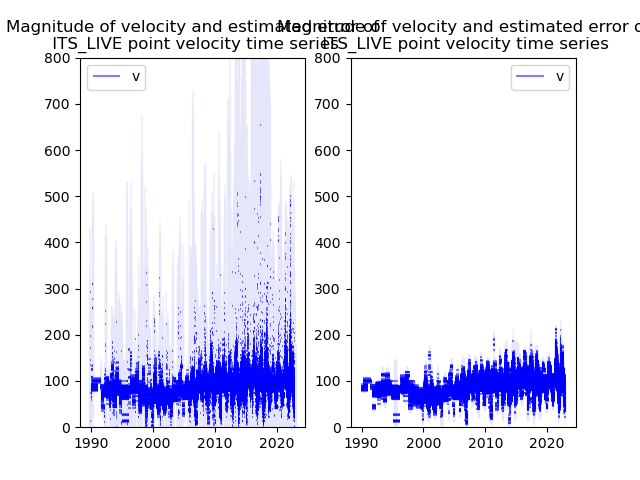

In [28]:
#| hide 

fig, (ax,ax1) = plt.subplots(ncols=2)
ax1.errorbar(y=df_sub['v'], yerr = df_sub['v_error'], x = df_sub['time_numeric'], color='lavender', linestyle='None', alpha=0.5)
ax1.hlines(xmin = df_sub['img1_numeric'], xmax = df_sub['img2_numeric'],y = df_sub['v'], color='blue', label='v',alpha=0.5)
ax1.set_ylim(0,800)
ax1.legend()
ax1.set_title('Magnitude of velocity and estimated error of\n ITS_LIVE point velocity time series');

ax.errorbar(y=df['v'], yerr = df['v_error'], x = df['time_numeric'], color='lavender', linestyle='None', alpha=0.5)
ax.hlines(xmin = df['img1_numeric'], xmax = df['img2_numeric'],y = df['v'], color='blue', label='v',alpha=0.5)
ax.set_ylim(0,800)
ax.legend()
ax.set_title('Magnitude of velocity and estimated error of\n ITS_LIVE point velocity time series');

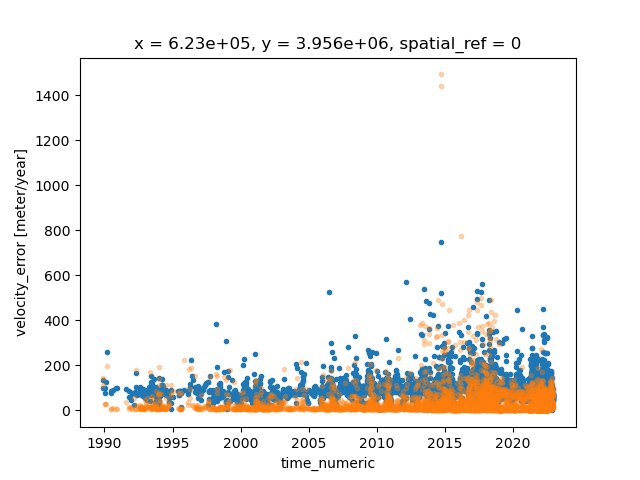

In [29]:
#| hide 

fig, ax = plt.subplots()
glacier_point.datacube_point.v.plot(ax=ax, linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=ax, linestyle='None', marker='o', alpha = 0.3, markersize=3);

This was just for one pixel. `Glacier_Point` also contains a 3x3 pixel cube surrounding the specified point to account for potential outlier estimates.

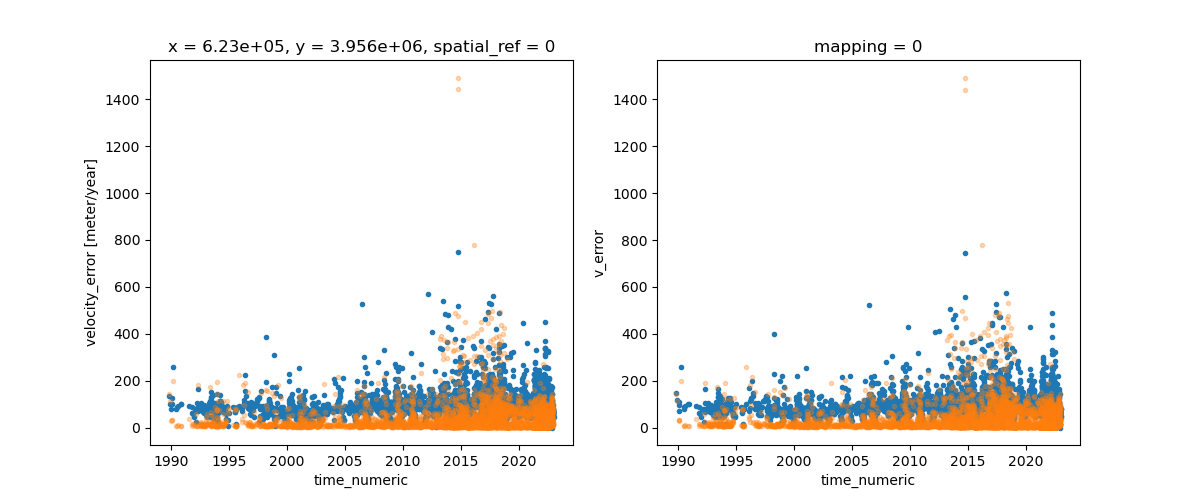

In [30]:
#| hide 

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
glacier_point.cube_around_point.v.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', markersize=3);
glacier_point.cube_around_point.v_error.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', alpha = 0.3, markersize=3);

glacier_point.datacube_point.v.plot(ax=axs[0], linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=axs[0], linestyle='None', marker='o', alpha = 0.3, markersize=3);

This comparison shows us that the trends we see in the single pixel plot are not too different from the pixels surrounding it. Good to know! 

Taking a look at this time series, we can see that there is interesting variability but also a fair amount of noise. This is where the regression methods become useful. 

Now we'll look at setting up the Gaussian Process model.

In [31]:
#| hide

point_ls = [glacier_point]

In [32]:
#| export
def prepare_ds(point_obj):

    '''note: i think this should be in its own notebook because its a different procss/step
       keeping here for now just to get an example going
       '''
    ds = point_obj.cube_around_point

    ds_sub = ds.where(ds.img_separation >= 60., drop=True)

    return ds, ds_sub

In [33]:
#| export
from sklearn.preprocessing import MinMaxScaler
import torch

class ModelInputs():
    '''this is a class to store model inputs for GP Regression. it is intended to store data for an individual temporal baseline category.
    '''
    def __init__(self, label, df, col, cutoffs):

        self.label = label
        self.df = df
        self.col = col
        self.cutoffs = cutoffs
        self.df_subset = self._filter_baselines()
        self.t_train, self.y_train, self.t_test, self.noise, self.scaled_y_train = self._organize_training_data()

    def _filter_baselines(self):
        df = self.df
        cutoffs = self.cutoffs
        df = df.dropna(subset=self.col)
        df_sub = df.loc[(df['img_separation'] >= cutoffs[0]) & (df['img_separation'] < cutoffs[1])]
        return df_sub

    def _organize_training_data(self):

        scaler = MinMaxScaler()
    
        t_train_np = self.df_subset.time_numeric.values
        y_train_np = self.df_subset[self.col].values
        model = scaler.fit(y_train_np.reshape(-1,1))
        scaled_y_train_np = model.transform(y_train_np.reshape(-1,1)).ravel()
    
        t_train_tensor = torch.Tensor(t_train_np)
        y_train_tensor = torch.Tensor(y_train_np)
        scaled_y_train_tensor = torch.Tensor(scaled_y_train_np)
    
        t_test_np = np.linspace(t_train_np.min(), t_train_np.max(), len(t_train_np))
        t_test_tensor = torch.Tensor(t_test_np)

        noise_tensor = torch.Tensor(self.df_subset['spatial_median_v_err'].values)
    
        
        return t_train_tensor, y_train_tensor, t_test_tensor, noise_tensor, scaled_y_train_tensor

In [34]:
#| export
def point_to_model_input(point_ls_obj, tb_category):

    point_ds, point_ds_sub = prepare_ds(point_ls_obj)

    #point_ds_sub = swap_time_dim(point_ds_sub)
    ds_new = point_ds_sub
    #ds_new = swap_time_dim(point_ds_sub)
    ds_new['spatial_median_v'] = (('time_numeric'), ds_new.v.median(dim=['x','y']).data)
    ds_new['spatial_median_v_err'] = (('time_numeric'), ds_new.v_error.median(dim=['x','y']).data)
    df = ds_new[['mid_date','spatial_median_v','time_numeric','img_separation','spatial_median_v_err']].to_dataframe().reset_index().dropna(subset='spatial_median_v')

    mod_input = ModelInputs(point_ls_obj.label, df, 'spatial_median_v', tb_category)

    return mod_input

In [35]:
#| export 
class SKLearnModelPreds():
    def __init__(self, inputs, kernel):
        self.inputs = inputs
        self.kernel = kernel
        #self.priors = priors
        self.t_train = self.inputs.t_train.numpy().reshape(-1,1)
        self.y_train = self.inputs.y_train.numpy().reshape(-1,1)
        self.t_test = self.inputs.t_test.numpy().reshape(-1,1)
        self.gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer='fmin_l_bfgs_b')
        self.y_pred, self.sigma, self.rmse = self.run_model()

    def run_model(self):

        self.gp.fit(self.t_train, self.y_train)
        y_pred, sigma = self.gp.predict(self.t_test, return_std=True)
        rmse = np.sqrt(((y_pred - self.y_train)**2).mean())
        return y_pred, sigma, rmse

In [36]:
#| export
mod_input_ls = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], [0,600])
    mod_input_ls.append(mod_input)

In [37]:
#| export
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RBF
from sklearn.model_selection import GridSearchCV

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) + Matern(length_scale=1.5, length_scale_bounds=(0.0, 10.0), nu = 1.5) + ExpSineSquared(length_scale=1, periodicity=1, length_scale_bounds = (0,10), periodicity_bounds=(1e-3, 10.0)) + WhiteKernel(noise_level=2., noise_level_bounds = (1e-6,1e3))

mod_output_ls = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls[i], kernel)
    mod_output_ls.append(mod_output)

In [40]:
#| hide 
%matplotlib widget

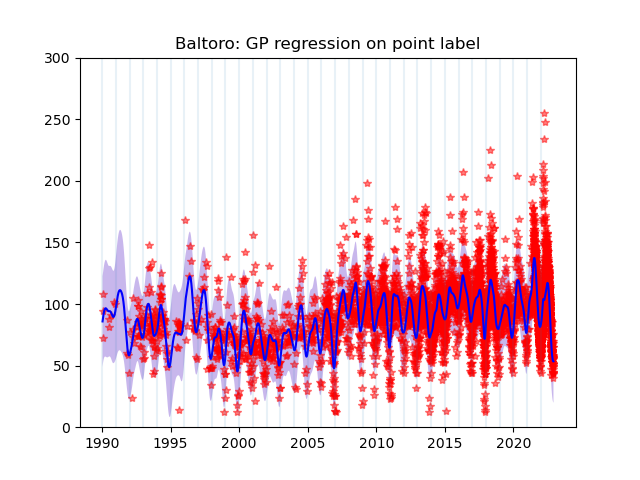

In [41]:
#| hide
fig, ax = plt.subplots()

ax.plot(mod_output_ls[0].t_train, mod_output_ls[0].y_train, 'r*', alpha = 0.5)
ax.plot(mod_output_ls[0].t_test, mod_output_ls[0].y_pred, c='blue')
ax.fill_between(mod_output_ls[0].t_test.ravel(),
                          mod_output_ls[0].y_pred + 1.96 * mod_output_ls[0].sigma,
                          mod_output_ls[0].y_pred - 1.96 * mod_output_ls[0].sigma,
                          facecolor='mediumpurple',alpha = 0.5)
x_ls = np.arange(1990, 2023, 1)
    

ax.set_ylim(0,300)
ax.set_title(f'Baltoro: GP regression on point {point_ls[0].label}')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
for x in x_ls:
    ax.axvline(x = x, alpha=0.1);
    

In [ ]:
# somewhere in this notebook a time sereis plot with horizontal bars corresponidng to temporal baseline should be added to convey different types of ice movement meaersurements

In [ ]:
#| hide 

import nbdev.showdoc as showdoc

In [ ]:
#| hide 

showdoc.show_doc(obj_setup.Glacier_Point.point_to_gdf)

---

[source](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/ITS_LIVE_TOOL/obj_setup.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Glacier_Point.point_to_gdf

>      Glacier_Point.point_to_gdf ()

In [ ]:
#| hide 

showdoc.show_doc(obj_setup.create_glacier_from_click)

---

[source](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/ITS_LIVE_TOOL/obj_setup.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### create_glacier_from_click

>      create_glacier_from_click (w_obj, i)

this function takes clicked information (from a single click, not all clicked points) and returns a `Glacier` type object